# Gaussian Distributions in Hyperbolic space
`Drew Wilimitis`

Recent publications have demonstrated how to produce a Gaussian like distribution on hyperbolic space, which is the foundation of probabilistic models. Gaussian Mixture models and Expectation-Maximization (EM) have several advantages over KMeans clustering, such as providing probabilistic or fuzzy classifications and not requiring KMeans assumptions like 'circularity'.   <br>
<br>
I'll first explore the formulation of the pseudo-Gaussian, Wrapped Normal Distribution in the hyperboloid model **[1]**, and then I'll explore another proposal that gives an explicit form of a Gaussian distribution in the Poincaré disk **[2]**. <br>

Finally, I will then attempt to use the hyperbolic gaussian distribution with the Expectation-maximization algorithm to implement a gaussian mixture model in hyperbolic space.

## Load libraries and helper functions

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import networkx as nx
import sys
import os

# import modules within repository
sys.path.append('C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\utils') # path to utils folder
sys.path.append('C:\\Users\\dreww\\Desktop\\frechet-mean-hyperboloid')
from manifold import *
from plotting import *
from utils import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

## Method 1: Wrapped Normal Distribution in the Lorentz Model

The wrapped normal distribution presented in **[1]** has the advantage of offering a fully differentiable probability density function, which is highly advantageous for gradient descent algorithms. This contruction might involve complications, however, with its projections and transformations between spaces. 

**Lorentz Model Background & Definitions** <br>

Lorentz model has simpler closed form geodesics and particularly cleaner expressions for the exponential map and parallel transport. <br>

We have the lorentzian product:
$$
\left\langle\boldsymbol{z}, \boldsymbol{z}^{\prime}\right\rangle_{\mathcal{L}}=-z_{0} z_{0}^{\prime}+\sum_{i=1}^{n} z_{i} z_{i}^{\prime}
$$ <br>
which we use to define the hyperboloid/Lorentz model as the following set:

$$
\mathbb{H}^{n}=\left\{\boldsymbol{z} \in \mathbb{R}^{n+1}:\langle\boldsymbol{z}, \boldsymbol{z}\rangle_{\mathcal{L}}=-1, \quad z_{0}>0\right\}
$$ <br>

The lorentzian distance is given by: $$
d_{\ell}\left(\boldsymbol{z}, \boldsymbol{z}^{\prime}\right)=\operatorname{arccosh}\left(-\left\langle\boldsymbol{z}, \boldsymbol{z}^{\prime}\right\rangle_{\mathcal{L}}\right)
$$ <br>

and finally we set this vector as the origin: 
$$
\boldsymbol{\mu}_{0}=[1,0,0, \ldots .0] \in \mathbb{H}^{n} \subset \mathbb{R}^{n+1}
$$

**Parallel transport** <br>

Parallel transport takes some $v$ to $u$ by mapping between tangent spaces $T_{\nu} \mathbb{H}^{n}$ to $T_{\mu} \mathbb{H}^{n}$ along the geodesic in a parallel manner<br>
<br>

$$
\mathrm{PT}_{\nu \rightarrow \mu}(\boldsymbol{v})=\boldsymbol{v}+\frac{\langle\boldsymbol{\mu}-\alpha \boldsymbol{\nu}, \boldsymbol{v}\rangle_{\mathcal{L}}}{\alpha+1}(\boldsymbol{\nu}+\boldsymbol{\mu})
$$ where $\alpha=-\langle\boldsymbol{v}, \boldsymbol{\mu}\rangle_{\mathcal{L}}$


**Exponential Map** <br>

The exponential map: $\exp _{\mu}: T_{\mu} \mathbb{H}^{n} \rightarrow \mathbb{H}^{n}$  projects some vector $u$ from a tangent space of the hyperboloid to a vector $z \in \mathbb{H}^{n}$
<br>

$$
z=\exp _{\mu}(\boldsymbol{u})=\cosh \left(\|\boldsymbol{u}\|_{L}\right) \boldsymbol{\mu}+\sinh \left(\|\boldsymbol{u}\|_{L}\right) \frac{\boldsymbol{u}}{\|\boldsymbol{u}\|_{\mathcal{L}}}
$$

**Logarithm Map (Inverse Exponential Map)** <br>

The inverse exponential map projects some vector $z$ from the hyperboloid back to the tangent space of the hyperboloid:
<br>

$$\boldsymbol{u}=\exp _{\boldsymbol{\mu}}^{-1}(\boldsymbol{z})=\frac{\operatorname{arccosh}(\alpha)}{\sqrt{\alpha^{2}-1}}(\boldsymbol{z}-\alpha \boldsymbol{\mu})$$ <br>
where $\alpha=-\langle\boldsymbol{\mu}, \boldsymbol{z}\rangle_{\mathcal{L}}$

___
**Algorithm 1:** Sampling from hyperbolic gaussian distribution $\mathcal{G}(\boldsymbol{\mu}, \Sigma)$ with $\mu \in \mathbb{H}^{n}$ and positive definite $\Sigma .$
___ 

1. Sample a vector ${\boldsymbol{v}^{*}}$ from the Gaussian distribution $\mathcal{N}(\mathbf{0}, \mathbf{\Sigma}) \text { defined over } \mathbb{R}^{n}$
2. Interpret ${\boldsymbol{v}^{*}}$ as an element of $T_{\boldsymbol{\mu}_{0}} \mathbb{H}^{n} \subset \mathbb{R}^{n+1}$ by rewriting
$ {\boldsymbol{v}^{*}} \text { as } \boldsymbol{v}=[0, {\boldsymbol{v}^{*}}]$<br>

3. Parallel transport the vector $\boldsymbol{v} \ $  to  $\ \boldsymbol{u} \in T_{\boldsymbol{\mu}} \mathbb{H}^{n} \subset \mathbb{R}^{n+1}$
along the geodesic from $\mu_{0}$ to $\mu$ <br>

4. Map $u$ to $\mathbb{H}^{n}$ by $\exp _{\mu}$

___

In [322]:
# first get sample from standard multivariate gaussian 
def init_sample(dim=2, variance=None):
    """Sample v from normal distribution in R^n+1 with N(0, sigma)"""
    mean = np.zeros((dim))
    if variance is None:
        variance = np.eye(dim)
    v = np.random.multivariate_normal(mean, variance)
    tangent_0 = np.insert(v, 0, 0)
    return tangent_0

# define alternate minkowski/hyperboloid bilinear form
def lorentz_product(u, v):
    """Compute lorentz product with alternate minkowski/hyperboloid bilinear form"""
    return -u[0]*v[0] + np.dot(u[1:], v[1:])

def lorentz_norm(u, eps=1e-5):
    """Compute norm in hyperboloid using lorentz product"""
    return np.sqrt(np.max([lorentz_product(u,u), eps]))

def parallel_transport(transport_vec, target_vec, base_vec, eps=1e-5):
    """Mapping between tangent spaces, transports vector along geodesic from v to u""" 
    alpha = -lorentz_product(base_vec, target_vec)
    frac = lorentz_product(target_vec - alpha*base_vec, transport_vec) / (alpha+1+eps)
    return transport_vec + frac*(base_vec + target_vec)

def exp_map(u, mu):
    """Given v in tangent space of u, we project v onto the hyperboloid surface""" 
    first = np.cosh(lorentz_norm(u)) * mu 
    last = np.sinh(lorentz_norm(u)) * (u / lorentz_norm(u))
    return first + last

def log_map(z, mu, eps=1e-5):
    """Given z in hyperboloid, we project z onto the tangent space at mu""" 
    alpha = -lorentz_product(mu, z)
    numer = np.arccosh(alpha) * (z - alpha*mu) 
    denom = np.sqrt(max(alpha**2 - 1, eps))
    return numer / denom

def hyperbolic_sampling(n_samples, mean, sigma, dim=2, poincare=False):
    """Generate n_samples from the wrapped normal distribution in hyperbolic space"""
    data = []
    mu_0 = np.insert(np.zeros((dim)), 0, 1) 
    for i in range(n_samples):
        init_v = init_sample(dim=dim, variance=sigma)
        tangent_u = parallel_transport(base_vec=mu_0, target_vec=mean, transport_vec=init_v)
        data.append(exp_map(tangent_u, mean))
    data = np.array(data)
    if poincare:
        return hyperboloid_pts_to_poincare(data, metric='minkowski')
    else:
        return data

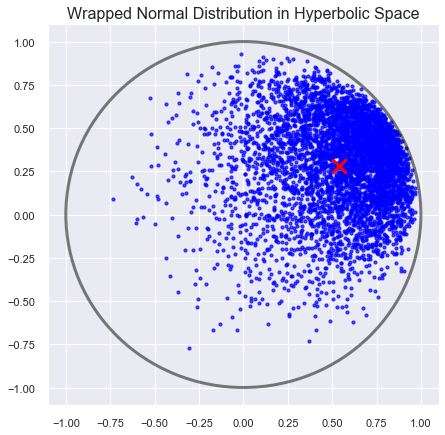

In [360]:
# draw n samples from wrapped normal distribution and map to poincare ball
n = 5000
test_mean = poincare_pt_to_hyperboloid(generate_data(1, radius=0.7)[0], metric='minkowski')
test_cov = np.eye(2)
gaussian_samples = hyperboloid_pts_to_poincare(hyperbolic_sampling(n, test_mean, test_cov**2), metric='minkowski')

# plot samples from wrapped normal distribution in poincare ball
plt.figure(figsize=(7,7))
sns.set()
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.scatter(gaussian_samples[:, 0], gaussian_samples[:, 1], c='blue', s=10, alpha=0.7)
plt.scatter(hyperboloid_pt_to_poincare(test_mean, metric='minkowski')[0], hyperboloid_pt_to_poincare(test_mean, metric='minkowski')[1],
            s=200, c='red', edgecolor='black', marker='x', linewidth=3)
plt.title('Wrapped Normal Distribution in Hyperbolic Space', size=16)
plt.show();

___
**Algorithm 2:** Calculate log-pdf
___

$\text { Input: sample } \boldsymbol{z} \in \mathbb{H}^{n}, \text { parameter } \boldsymbol{\mu} \in \mathbb{H}^{n}, \Sigma$ <br>
$\text { Output: } \log p(\boldsymbol{z})$<br>
$\text { Require: } \boldsymbol{\mu}_{0}=(1,0, \cdots, 0)^{\top} \in \mathbb{H}^{n} $<br>
1. $\text { Map } \boldsymbol{z} \text { to } \boldsymbol{u}=\exp _{\boldsymbol{\mu}}^{-1}(\boldsymbol{z}) \in T_{\boldsymbol{\mu}} \mathbb{H}^{n} $<br>
2. $\text { Move } \boldsymbol{u} \text { to } \boldsymbol{v}=\mathrm{P} \mathrm{T}_{\boldsymbol{\mu}_{0} \rightarrow \boldsymbol{\mu}}^{-1}(\boldsymbol{u}) \in T_{\boldsymbol{\mu}_{0}} \mathbb{H}^{n} $<br>
3. $\text { Calculate } \log p(\boldsymbol{z})$

$$\log p(\boldsymbol{z})=\log p(\boldsymbol{v})-\log \operatorname{det}\left(\frac{\partial \operatorname{proj}_{\boldsymbol{\mu}}(\boldsymbol{v})}{\partial \boldsymbol{v}}\right)$$<br>

$$\operatorname{det}\left(\frac{\partial \operatorname{proj}_{\mu}(\boldsymbol{v})}{\partial \boldsymbol{v}}\right)=\left(\frac{\sinh r}{r}\right)^{n-1}$$
with $r=\|\boldsymbol{u}\|_{\mathcal{L}}$

In [345]:
from scipy.stats import multivariate_normal
def log_pdf(z, mu, sigma):
    """Given sample z and parameters mu, sigma calculate log of p.d.f(z)""" 
    n = len(z) - 1
    mu_0 = np.insert(np.zeros((n)), 0, 1)
    u = log_map(z, mu)
    v = parallel_transport(transport_vec=u, target_vec=mu_0, base_vec=mu)
    r = lorentz_norm(u)
    det_proj = (np.sinh(r) / r)**(n-1)
    pv = multivariate_normal.pdf(v[1:], mean=np.zeros((n)), cov=sigma)
    return np.log10(pv) - np.log10(det_proj)

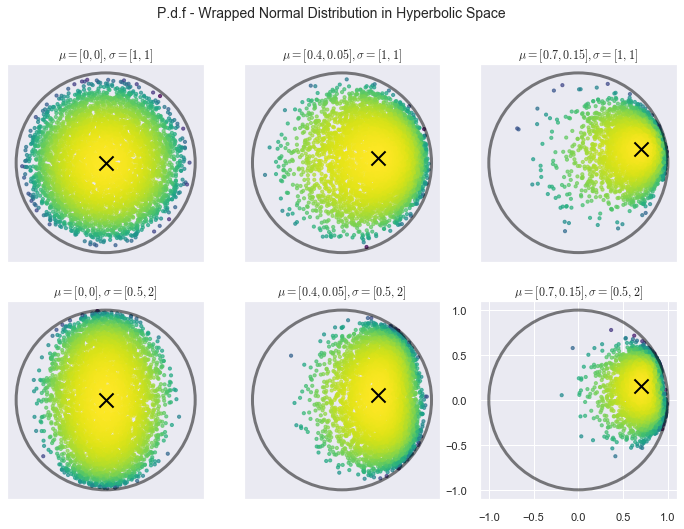

In [361]:
# set parameters
n = 5000
test_means = [[0, 0], [0.4, 0.05], [0.7, 0.15]]
test_sigmas = [[1, 1], [0.5, 2]]

# plot log pdf for each pair of parameters
fig, axs = plt.subplots(2,3, figsize=(12, 8))
axs = axs.ravel()
for i in range(6):
    test_mu = poincare_pt_to_hyperboloid(test_means[i%3], metric='minkowski')
    test_sigma = np.diag(test_sigmas[int(i/3)])
    gaussian_samples = hyperbolic_sampling(n, test_mu, test_sigma)
    Z = np.array([log_pdf(z, mu=test_mu, sigma=test_sigma) for z in gaussian_samples])
    gaussian_samples = hyperboloid_pts_to_poincare(gaussian_samples, metric='minkowski')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax = axs[i]
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
    ax.add_patch(circ)
    ax.scatter(gaussian_samples[:, 0], gaussian_samples[:, 1], c=Z, s=10, alpha=0.7, cmap='viridis')
    ax.scatter(hyperboloid_pt_to_poincare(test_mu, metric='minkowski')[0], hyperboloid_pt_to_poincare(test_mu, metric='minkowski')[1],
                s=200, c='black', edgecolor='black', marker='x', linewidth=2)
    ax.set_title('$\mu = {}, \sigma = {}$'.format(str(test_means[i%3]), str(test_sigmas[int(i/3)])));

plt.suptitle('P.d.f - Wrapped Normal Distribution in Hyperbolic Space', size=14)
plt.show();

## Method 2: Explicitly defined Gaussian in the Poincare Disk

A closed form expression for the gaussian density is highly advantageous, however, this density is not fully differentiable and might make it significantly harder to sample from this gaussian density in hyperbolic space.

$$
p(\mathbf{x} | \boldsymbol{\mu}, \boldsymbol{\sigma})=\frac{1}{Z(\boldsymbol{\sigma})} e^{-\frac{d^{2}(\boldsymbol{x}, \boldsymbol{\mu})}{2 \sigma^{2}}} \quad Z(\boldsymbol{\sigma})=2 \pi \sqrt{\frac{\pi}{2}} \boldsymbol{\sigma} e^{\frac{\sigma^{2}}{2}} \operatorname{erf}\left(\frac{\boldsymbol{\sigma}}{\sqrt{2}}\right)
$$ <br>
Error function term given by: $$
\begin{aligned}
\operatorname{erf}(x) &=\frac{1}{\sqrt{\pi}} \int_{-x}^{x} e^{-t^{2}} d t \\
&=\frac{2}{\sqrt{\pi}} \int_{0}^{x} e^{-t^{2}} d t
\end{aligned}
$$

The density is somewhat similar to the Euclidean case, but here the distance $d(\boldsymbol{x}, \boldsymbol{\mu})$ becomes the Poincaré distance, and the parameters are the Frechet mean $\boldsymbol{\mu}$, and the dispersion $\sigma > 0$.

In [ ]:
def uniform_sample_hyperboloid_disc(max_distance, centre=None):
    """
    Return a sample drawn uniformly at random from the disc of
    radius `max_distance` on the hyperboloid.
    NOTE: formula is specific to the case of local-dimension 2.
    """
    rank = 2
    tangent = np.random.randn(rank + 1)
    tangent[rank] = 0
    tangent /= np.sqrt(tangent.dot(tangent))
    # we use inversion sampling: invert the CDF, apply result to uniform random samples from [0,1]
    p = np.random.uniform()
    tangent *= np.arccosh(1 + p * (np.cosh(max_distance) - 1))
    basept = coordinate_vector(rank, rank + 1)
    if centre is None:
        centre = basept
    else:
        centre_log = logarithm(basept, centre)
        tangent = geodesic_parallel_transport(basept, centre_log, tangent)
    return exponential(centre, tangent)

## Standard EM Algorithm with Gaussian Mixture Models

**Input**: Training data  $x_1, \ldots , x_n\in \mathbb{R}^{d}$ and specified number of source components/gaussian clusters $k$:<br>

**Goal**: Perform clustering on input data and return cluster assignments <br>
1. **Initialization step**: Initialize gaussian mean, covariance $(\mu_k , \Sigma_k)$ for each gaussian cluster $\mathcal{G}(\boldsymbol{\mu_k}, \Sigma_k)$ and initialize cluster assignments<br>
2. **E-step**: For each data point $x_i$, and for each cluster label $k$, compute probability $p\left(y_{i}=k | x_{i}, \Theta^{(t)}\right)$ of class assignment <br>
3. **M-step**: Update parameters $\Theta^{(t+1)}$ by computing new means and covariances based on updated class assignment probabilities <br>
4. **Repeat steps 2-3 until stopping criteria** <br>
5. **Return:** cluster labels for all $x_i$ and final parametrized gaussian cluster $\mathcal{G_k}(\boldsymbol{\mu_k}, \Sigma_k)$ for all $k$

### Expectation Step: Assign likelihoods given parameters

For each data point $x_i$, and for each cluster $k$, compute likelihood of the data point given the cluster assignment $k$ with parameters $(\mu_k, \Sigma_k) $, and we then call this $w_{ik}$. We ensure the sum is equal to 1 for a given data point. $w_{i 1}+w_{i 2}+\ldots+w_{i K}=1$<br>
<br>
and we have each probability that $x_i$ drawn from k-th cluster as: <br>

$$w_{i k}=\frac{\pi_{k} N\left(x_{i} | \mu_{k}, \Sigma_{k}\right)}{\sum_{k=1}^{K} \pi_{k} N\left(x_{i} | \mu_{k}, \Sigma_{k}\right)}$$ <br>
where $\pi_k$ is the cluster weight computed below and we divide by the normalization term

### Maximization Step: Update parameters given likelihoods

First we compute soft counts $N_{k}^{\mathrm{soft}}=w_{1 k}+w_{2 k}+\ldots+w_{N k}=\sum_{i=1}^{N} w_{i k}$, which we use to update cluster weights: $\hat{\pi}_{k}=\frac{N_{k}^{\mathrm{soft}}}{N}$<br>
<br>
Then we need to update the mean by estimating the Riemannian barycenter:<br>

$$\hat{\mu}_{k}=\arg \min _{\mu} \sum_{i=1}^{N} w_{i k} d^{2}\left(\mu, x_{i}\right)$$ <br>

Finally we update standard deviation by solving the optimization problem:<br>

$$\hat{\sigma_{k}}=\underset{\sigma_{s}}{\operatorname{argmin}}\left|\left(\frac{1}{\sum_{i=0}^{N} w_{i k}} \sum_{i=0}^{N} d^{2}\left(\mu_{k}, x_{i}\right) w_{i k}\right)-\Phi^{-1}\left(\sigma_{s}\right)\right|$$ <br>

where $\Phi: \mathbb{R}_{+} \longrightarrow \mathbb{R}_{+}$, given by the inverse of $\sigma \mapsto \sigma^{3} \times \frac{d}{d \sigma} \log \zeta_{m}(\sigma)$<br>

and we have the following forms for zeta:<br>

$$\zeta_{m}(\mu, \sigma)=\zeta_{m}(0, \sigma)=\zeta_{m}(\sigma)=\int_{\mathbb{B}^{m}} \exp \left[-\frac{d^{2}(x, 0)}{2 \sigma^{2}}\right] d v(x)$$<br>
<br>
$$\zeta_{m}(\sigma)=\sqrt{\frac{\pi}{2}} \frac{\sigma}{2^{m-1}} \sum_{k=0}^{m-1}(-1)^{k} C_{m-1}^{k} e^{\frac{p_{k}^{2} \sigma^{2}}{2}}\left(1+\operatorname{erf}\left(\frac{p_{k} \sigma}{\sqrt{2}}\right)\right)$$

In [386]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
my_path = 'C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\utils' # path to utils.py 
sys.path.append(my_path)
from utils import *

#-------------------------------------------------------------------
#----- Riemannian Barycenter Optimization in Hyperboloid Model -----
#-------------------------------------------------------------------

def exp_map(v, theta_k, eps=1e-6):
    """ Exponential map that projects tangent vector v onto hyperboloid"""
    # v: vector in tangent space at theta_k
    # theta: parameter vector in hyperboloid with centroid coordinates
    # project vector v from tangent minkowski space -> hyperboloid"""
    return np.cosh(norm(v))*theta_k + np.sinh(norm(v)) * v / (norm(v) + eps)

def minkowski_distance_gradient(u, v):
    """ Riemannian gradient of hyperboloid distance w.r.t point u """ 
    # u,v in hyperboloid
    return -1*(hyperboloid_dot(u,v)**2 - 1)**-1/2 * v

def minkowski_loss_gradient(theta_k, X, w):
    """ Riemannian gradient of error function w.r.t theta_k """
    # X : ALL data x1, ..., xN (not just within clusters like K-means) - shape N x 1
    # theta_k: point in hyperboloid at cluster center
    # w: vector with weights w_1k, ..., w_Nk - shape N x 1
    # returns gradient vector
    weighted_distances = w*np.array([-1*hyperboloid_dist(theta_k, x) for x in X]) # scalar
    distance_grads = np.array([minkowski_distance_gradient(theta_k, x) for x in X]) # list of vectors
    grad_loss = 2*np.sum(weighted_distances*distance_grads, axis=0) # summing along list of vectors
    if np.isnan(grad_loss).any():
        #print('Hyperboloid dist returned nan value')
        return eps
    else:
        return grad_loss

In [393]:
def project_to_tangent(theta_k, minkowski_grad):
    """ 
    Projects vector in ambient space to hyperboloid tangent space at theta_k 
    Note: returns our hyperboloid gradient of the error function w.r.t theta_k
    """
    # minkowski_grad: riemannian gradient vector in ambient space
    # theta_k: point in hyperboloid at cluster center
    return minkowski_grad + hyperboloid_dot(theta_k, minkowski_grad)*theta_k

def update_step(theta_k, hyperboloid_grad, alpha=0.1):
    """ 
    Apply exponential map to project the gradient and obtain new cluster center
    Note: returns updated theta_k
    """
    # theta_k: point in hyperboloid at cluster center
    # hyperboloid_grad: hyperboloid gradient in tangent space
    # alpha: learning rate > 0
    new_theta_k = exp_map(-1*alpha*hyperboloid_grad, theta_k)
    return 

def barycenter_loss(theta_k, X, w):
    """ Evaluate barycenter loss for a given gaussian cluster """
    # X : ALL data x1, ..., xN (not just within clusters like K-means) - shape N x 1
    # theta_k: parameter matrix with cluster center points - 1 x n
    # w: weights w_1k, ..., w_Nk - shape N x 1
    distances = np.array([hyperboloid_dist(theta_k, x)**2 for x in X])
    weighted_distances = w * distances
    loss = np.sum(weighted_distances)
    return loss

def overall_loss(theta, X, W):
    """ Evaluate barycenter loss for a given gaussian cluster """
    # X : ALL data x1, ..., xN (not just within clusters like K-means) - shape N x 1
    # theta: parameter matrix with cluster center points - k x n
    # W: matrix with weights w_1k, ..., w_Nk - shape k x N
    loss = 0
    K = W.shape[1]
    for i in range(K):
        distances = np.array([hyperboloid_dist(theta[i], x)**2 for x in X])
        weighted_distances = W[i, :] * distances
        loss += np.sum(weighted_distances)
    return loss

def weighted_barycenter(theta_k, X, w, num_rounds = 10, alpha=0.3, tol = 1e-4, verbose=False):
    """ Estimate weighted barycenter for a gaussian cluster with optimization routine """
    # X : ALL data x1, ..., xN (not just within clusters like K-means) - shape N x 1
    # theta_k: parameter matrix with cluster center points - k x n
    # w: weights w_1k, ..., w_Nk - shape N X 1
    # num_rounds: training iterations
    # alpha: learning rate
    # tol: convergence tolerance, exit if updates smaller than tolerance
    centr_pt = theta_k
    centr_pts = [theta_k]
    losses = []
    for i in range(num_rounds):
        gradient_loss = minkowski_loss_gradient(centr_pt, X, w)
        tangent_grad = project_to_tangent(centr_pt, -gradient_loss)
        centr_pt = update_step(centr_pt, tangent_grad, alpha=alpha)
        centr_pts.append(centr_pt)
        losses.append(barycenter_loss(centr_pt, X, w))
        if verbose:
            print('Epoch ' + str(i+1) + ' complete')
            print('Loss: ', barycenter_loss(centr_pt, X, w))
            print('\n')
        if hyperboloid_dist(centr_pts[i+1], centr_pts[i]) < tol:
            break
    return centr_pt

## References
___

**[1]** Nagano, Y., Yamaguchi, S., Fujita, Y., & Koyama, M. (2019). A Differentiable Gaussian-like Distribution on Hyperbolic Space for Gradient-Based Learning. ArXiv, abs/1902.02992. <br>

**[2]** Ovinnikov, Ivan. “Poincaré Wasserstein Autoencoder.” ArXiv abs/1901.01427 (2019): n. pag.